In [1]:
import cv2
import numpy as np
import matplotlib . pyplot as plt

img_width = 640
img_height = 480
image_size = ( img_width , img_height )
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_FIX_SKEW

def calibration1(side):
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_FIX_SKEW
    # inner size of chessboard

    width = 9
    height = 6
    square_size = 0.025 # 0.025 meters

    # prepare object points , like (0 ,0 ,0) , (1 ,0 ,0) , (2 ,0 ,0) .... ,(8 ,6 ,0)
    objp = np.zeros((height * width, 1, 3), np.float64)
    objp[: , 0, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)
    objp = objp * square_size # Create real world coords . Use your metric .

    # Arrays to store object points and image points from all the images .
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane
    img_width = 640
    img_height = 480
    image_size = ( img_width , img_height )

    path = ""
    image_dir = path + "pairs/"
    # image_dir = path + "fixed/"

    number_of_images = 8

    for i in range (1, number_of_images):
    # read image
        
        if i == 30:
            continue
        
        img = cv2.imread(image_dir + f"{side}_%02d.png" % i)
        gray = cv2.cvtColor (img, cv2.COLOR_BGR2GRAY)
        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (width, height), cv2.
            CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.
            CALIB_CB_NORMALIZE_IMAGE )
        Y, X, channels = img.shape
        # skip images where the corners of the chessboard are too close to the edges of the image
        if (ret == True):
            minRx = corners[:, :, 0].min()
            maxRx = corners[:, :, 0].max()
            minRy = corners[:, :, 1].min()
            maxRy = corners[:, :, 1].max()

            border_threshold_x = X /12
            border_threshold_y = Y /12

            x_thresh_bad = False
            if ( minRx < border_threshold_x ):
                x_thresh_bad = True

            y_thresh_bad = False
            if ( minRy < border_threshold_y ):
                y_thresh_bad = True

            if ( y_thresh_bad == True ) or ( x_thresh_bad == True ):
                continue

        # If found , add object points , image points ( after refining them )
        if ret == True :
            objpoints.append(objp)

            # improving the location of points (sub - pixel )
            corners2 = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)

            imgpoints.append(corners2)

            # Draw and display the corners
            # Show the image to see if pattern is found ! imshow function .
            cv2.drawChessboardCorners(img, (width, height), corners2, ret)
            cv2.imshow("Corners", img )
            cv2.waitKey(5)
        else :
            print ("Chessboard couldn't be detected. Image pair: ", i)
            continue
    return objpoints, imgpoints
        
cv2.destroyAllWindows()


In [2]:
objpoints, imgpoints = calibration1('left')

def calibration2(objp, imgp):
    N_OK = len(objp)
    K = np.zeros((3, 3))
    D = np.zeros((4, 1))
    rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range (N_OK)]
    tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range (N_OK)]
    ret, K, D, _, _= \
            cv2.fisheye.calibrate(
            objp,
            imgp,
            image_size,
            K,
            D,
            rvecs,
            tvecs,
            calibration_flags,
            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
        )
    # Let ’s rectify our results
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, image_size,
        cv2.CV_16SC2)
    
    print(f"ret: {ret}\nK: {K}\nD: {D}\nrvecs: {rvecs}\ntvecs: {tvecs}\n")
    
    return map1, map2, K, D



ret: 0.10389180945498416
K: [[338.43640528   0.         344.51129893]
 [  0.         338.29052128 234.65140868]
 [  0.           0.           1.        ]]
D: [[-0.02840304]
 [ 0.00591358]
 [-0.03589908]
 [ 0.02931296]]
rvecs: [array([[[0., 0., 0.]]]), array([[[0., 0., 0.]]]), array([[[0., 0., 0.]]]), array([[[0., 0., 0.]]]), array([[[0., 0., 0.]]]), array([[[0., 0., 0.]]]), array([[[0., 0., 0.]]])]
tvecs: [array([[[0., 0., 0.]]]), array([[[0., 0., 0.]]]), array([[[0., 0., 0.]]]), array([[[0., 0., 0.]]]), array([[[0., 0., 0.]]]), array([[[0., 0., 0.]]]), array([[[0., 0., 0.]]])]



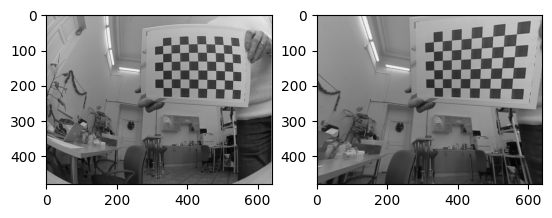

: 

In [4]:
map1, map2, _, _ = calibration2(objpoints, imgpoints)

image = cv2.imread('pairs/left_01.png')
undistorted_image = cv2.remap(image, map1, map2, interpolation=cv2.INTER_LINEAR,
    borderMode=cv2.BORDER_CONSTANT)

f, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[1].imshow(undistorted_image)
plt.show()

In [ ]:
number_of_images = 50

for i in range (1, number_of_images):
    img = cv2.imread('pairs/' + "left_%02d.png" % i)
    undistorted_image = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT)

    # f, ax = plt.subplots(1, 2, figsize=(18, 10))
    # ax[0].imshow(img)
    # ax[1].imshow(undistorted_image)
    # plt.show()